# Haystack Tutorial: Building Your First RAG Pipeline

Welcome to this tutorial on **Haystack**! Haystack is an open-source framework for building applications with Large Language Models (LLMs). It provides the tools to build powerful and flexible applications like question-answering systems, semantic search, and complex, multi-step agentic workflows.

In this notebook, we'll focus on one of the most common and powerful use cases: **Retrieval-Augmented Generation (RAG)**. A RAG pipeline allows your LLM to answer questions based on your own data, which helps to ground the model's responses in facts and reduce hallucinations.

We will cover the following:

* **Core Haystack Concepts**: We'll get to know the essential building blocks of Haystack.
* **Building a RAG Pipeline**: We'll construct a simple pipeline to answer questions about a set of documents.
* **Running the Pipeline**: We'll see how to execute the pipeline and get answers to our questions.

## 1. Installation

First, let's install the necessary packages. We'll need `haystack-ai` for the core Haystack library, `python-dotenv` to manage our API keys, and `huggingface-hub` to download a dataset.

In [1]:
# Uncomment the following line to install the required packages
# !pip install haystack-ai python-dotenv huggingface-hub -q
# Run this cell to fix the dependency issues
# !pip install --upgrade "transformers>=4.41.0" "tokenizers>=0.21,<0.22" "sentence-transformers>=4.1.0" -q

## 2. API Key Setup

We'll be using a model from Hugging Face, so you'll need a Hugging Face API key. Create a `.env` file in the same directory as this notebook and add your key like this:

In [8]:
import os
from dotenv import load_dotenv

load_dotenv()
# Use the correct environment variable name that matches your .env file
huggingface_api_key = os.getenv("HUGGINGFACE_ACCESS_TOKEN")

if huggingface_api_key:
    print("✅ Hugging Face API key loaded successfully!")
    # Set the environment variable for the Hugging Face API
    os.environ["HF_TOKEN"] = huggingface_api_key
else:
    print("❌ Hugging Face API key not found. Please check your .env file.")
    print("Make sure you have: HUGGINGFACE_API_KEY=your_actual_api_key")
    print("You can get your API key from: https://huggingface.co/settings/tokens")

✅ Hugging Face API key loaded successfully!


## 3. Core Haystack Concepts

Before we build our pipeline, let's focus on the three most important ideas in Haystack:

* **Components**: These are the building blocks of your application, such as embedders, retrievers, prompt builders, and generators. Each component performs a specific function in the workflow.
* **Pipeline**: A Pipeline connects multiple components together, defining the flow of data and logic to solve a specific task, such as answering a question or retrieving relevant documents.
* **Document Store**: This is where your data (documents) are stored and managed. It can be in-memory for small demos or a persistent database for production.

## 4. Building a RAG Pipeline

Now, let's put these concepts into practice. We'll build a RAG pipeline that can answer questions about a small dataset of articles.

In [4]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.generators.chat import HuggingFaceAPIChatGenerator
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.builders import ChatPromptBuilder
from haystack import Pipeline, Document
from haystack.utils import Secret
from haystack.dataclasses import ChatMessage

# 1. Setup Document Store
document_store = InMemoryDocumentStore()

# 2. Prepare sample documents
documents = [
    Document(content="Paris is the capital and most populous city of France. It is located in the north-central part of the country.", meta={"title": "Paris"}),
    Document(content="France is a country in Western Europe. It has several overseas regions and territories.", meta={"title": "France"}),
    Document(content="The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France.", meta={"title": "Eiffel Tower"})
]
document_store.write_documents(documents)

# 3. Initialize the Text Embedder
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")

# 4. Initialize the Retriever
retriever = InMemoryEmbeddingRetriever(document_store, top_k=2)

# 5. Initialize the Prompt Builder
template = [ChatMessage.from_user("""
{% for doc in documents %}
    {{ doc.content }}
{% endfor %}

Question: {{question}}
""")]

prompt_builder = ChatPromptBuilder(template=template)

# 6. Initialize the Generator
generator = HuggingFaceAPIChatGenerator(
    api_type="serverless_inference_api", 
    api_params={"model": "HuggingFaceH4/zephyr-7b-beta"}, 
    token=Secret.from_token(huggingface_api_key) if huggingface_api_key else None
)

# 7. Create the Pipeline
rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)

# 8. Connect the components
rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever.documents", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder.prompt", "llm.messages")

2025-08-05T04:21:09.343198Z [warning  ] ChatPromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`. length=2 lineno=193 module=haystack.components.builders.chat_prompt_builder


🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - llm: HuggingFaceAPIChatGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])

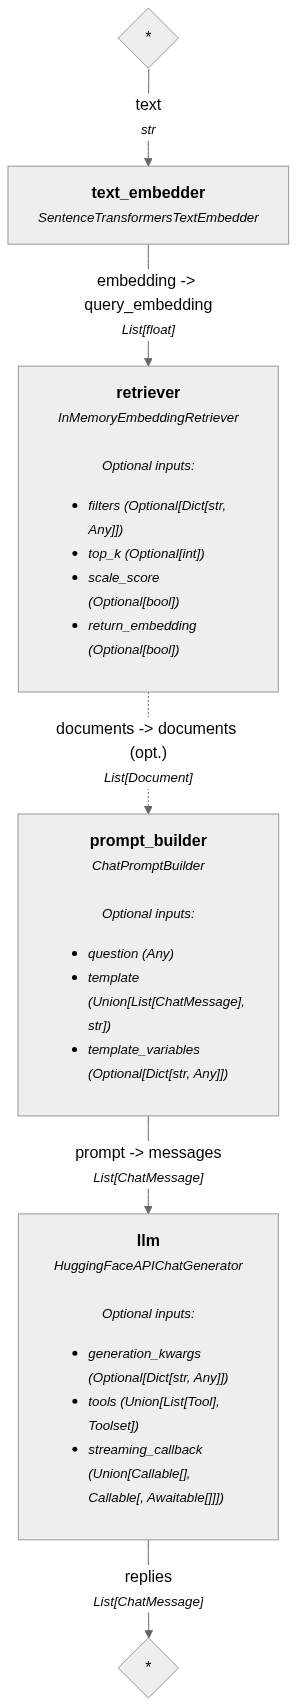

In [15]:
rag_pipeline.show()

## 5. Running the Pipeline

Now that our pipeline is built, let's ask it a question!

In [10]:
question = "What is the capital of France?"

result = rag_pipeline.run({
    "text_embedder": {"text": question},
    "prompt_builder": {"question": question}
})

print(result['llm']['replies'][0].text)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05T04:31:20.779161Z [warning  ] No Documents found with embeddings. Returning empty list. To generate embeddings, use a DocumentEmbedder. lineno=602 module=haystack.document_stores.in_memory.document_store




[CHECKER] 

Response: Paris is the largest city in France, but it is not the capital. The capital is actually Paris' neighbor to the east, the city of Paris being the similarly-named préfecture of the Île-de-France region, which contains many suburbs of Paris, such as Disneyland Paris. The capital of France is Paris' northern neighbor, the city of Versailles. In fact, Paris proper is administratively part of the département (county) of Seine-Saint-Denis, which is itself part of the région (region or state, roughly comparable to a U.S. State) of Île-de-France, which contains many other arrondissements (municipalities, roughly comparable to U.S. Cities), such as Saint-Denis, Aubervilliers, and Neuilly-sur-Seine, which in turn are part of the département of Hauts-de-Seine, which is part of Île-de-France. The capital of France is the city of Paris. The capital is Paris. The formal name of the city is la Ville de Paris (French: [la vì: də pa:riz]. The formal name of the country is the Rép

## 6. Conclusion

Congratulations! You've successfully built and run your first Haystack RAG pipeline. You've learned about the core components of Haystack and how to connect them to create a powerful question-answering system.

From here, you can explore more advanced features like:

* Using different `DocumentStore`
* Trying different `Retriever` and `Generator`
* Building more complex pipelines with custom components

Happy building!